In [283]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pylab as plt

pd.set_option('display.max_columns', None)

In [284]:
df = pd.read_csv('FINAL DF.csv')

In [5]:
df.head()

,Registration State,Plate Type,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Vehicle Expiration Date,Violation Time,Violation In Front Of Or Opposite,Sub Division,Vehicle Color,Vehicle Year,Feet From Curb,Year Set,Range,Date,Year,Month,Day,Violation County,longitude,latitude,xCoordinate,yCoordinate
1,1,7,1200,2,3,T,2020-10-27,11:03 AM,1.0,C,3,2016.0,0,2021,07:00AM - 04:00PM,2020-11-16,2020,11,16,2,-73.894742,40.852940,1013369.0,250044.0
3,1,7,1200,1,2,T,NaN,07:44 AM,2.0,C,1,NaN,0,2021,NaN,2021-05-12,2021,5,12,1,-73.955695,40.764199,996523.0,217698.0
4,1,7,400,2,1,T,2022-06-21,10:41 AM,1.0,D,1,2010.0,0,2021,10:30AM - 12:00AM,2020-12-31,2020,12,31,4,-73.819338,40.722798,1034327.0,202663.0
5,1,7,1200,1,1,T,2020-03-23,06:17 PM,1.0,C,3,2004.0,0,2020,07:00AM - 07:00PM,2020-02-24,2020,2,24,3,-73.958452,40.714723,995768.0,199672.0
6,1,7,400,1,1,T,NaN,08:41 AM,1.0,D,4,NaN,0,2021,08:00AM - 09:30AM,2020-10-09,2020,10,9,2,-73.890279,40.821662,1014618.0,238650.0


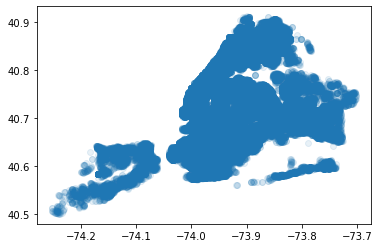

In [9]:
plt.scatter(df['longitude'], df['latitude'], alpha= 0.1)

In [306]:
df['Violation Code'].value_counts()

400     75952
900     62422
1200    42618
700     40270
600     18913
1400    18851
800      3453
1000     2600
1100      797
100       245
200       185
1700       88
300        31
1500       27
500        21
1600       19
1300       18
Name: Violation Code, dtype: int64

In [329]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

#collect Variables for PreProcessing 
#No rank or order amongst categorical vars

onehot_ftrs = ['Registration State', 'Plate Type', 'Vehicle Body Type', 'Vehicle Make',
               'Violation In Front Of Or Opposite', 'Sub Division', 'Vehicle Color', 'Violation County']

 
#numerical Data is imablanced, utilize std ftrs
std_ftrs = ['Violation Time', 'Vehicle Year', 'Feet From Curb', 'Year', 'Month', 'Day', 'longitude', 
            'latitude', 'Expiration Year', 'Expiration Month', 'Expiration Day']


#impute missing values for onehot
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

#convert numbers to standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

#collection of transformers the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, std_ftrs),
        ('cat', categorical_transformer, onehot_ftrs)])

y = df['Violation Code']
X = df.loc[:,df.columns != 'Violation Code']

In [335]:

def MLpipe_sss_accuracy(X, y, random_states):
    best_models = []
    best_params = []
    best_scores = []
    
    for i in random_states: 

        #split 80/20
        sss = StratifiedShuffleSplit(n_splits = 3, train_size=0.8, random_state = i)
        
        for train_i, other_i in sss.split(X,y):
            X_train, X_other = X.iloc[train_i], X.iloc[other_i]
            y_train, y_other = y.iloc[train_i], y.iloc[other_i]
             
            
            for val_i, test_i in sss.split(X_other,y_other):
                X_val, X_test = X.iloc[val_i], X.iloc[test_i]
                y_val, y_test = y.iloc[val_i], y.iloc[test_i]
                
                return y_train

In [356]:
60762/ 0.8*df.shape[0]

20242100775.0

In [339]:
MLpipe_sss_accuracy(X, y, seed_array).value_counts()

400     60762
900     49938
1200    34094
700     32216
600     15130
1400    15081
800      2762
1000     2080
1100      638
100       196
200       148
1700       70
300        25
1500       22
500        17
1600       15
1300       14
Name: Violation Code, dtype: int64

In [378]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import balanced_accuracy_score

def MLpipe_sss_accuracy(X, y, preprocessor, ML_algo, param_grid, random_states):
    best_models = []
    best_params = []
    best_scores = []
    
    for i in random_states: 

        #split 80/20
        sss = StratifiedShuffleSplit(n_splits = 3, train_size=0.8, random_state = i)
        
        for train_i, other_i in sss.split(X,y):
            X_train, X_other = X.iloc[train_i], X.iloc[other_i]
            y_train, y_other = y.iloc[train_i], y.iloc[other_i]
             
            
            for val_i, test_i in sss.split(X_other,y_other):
                X_val, X_test = X.iloc[val_i], X.iloc[test_i]
                y_val, y_test = y.iloc[val_i], y.iloc[test_i]
        
        #preprocess 
        prep_pipe = make_pipeline(preprocessor, ML_algo)

        #CV via paramgrid 
        g = GridSearchCV(prep_pipe, param_grid = param_grid, scoring = 'balanced_accuracy', verbose = True, cv = sss, return_train_score=True)
        g.fit(X_train,y_train)
        feature_names = std_ftrs + \
            list(g.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(onehot_ftrs))
        
        #best models 
        best_models.append(g.best_estimator_)
        
        #best parameters 
        best_params.append(g.best_params_)

        #calculate/save test score
        y_test_pred = best_models[-1].predict(X_test)
        test_scores = balanced_accuracy_score(y_test,y_test_pred)
        best_scores.append(test_scores)
    
    return g,  best_models, best_scores, best_params, y_test, y_test_pred, X_test, X_train, np.array(feature_names)

In [409]:
y_testrcc

22862     400
22135    1200
14678     400
19117    1200
31830    1200
         ... 
46745     700
16884    1200
12944    1200
34350    1400
47575    1200
Name: Violation Code, Length: 10661, dtype: int64

In [345]:
(0.08121890465827653/213208)**0.5

0.0006172012769897336

In [19]:
np.random.seed(0)
seed_array = np.random.randint(0,1000,3)
print(seed_array)

[684 559 629]


In [379]:
from sklearn.ensemble import RandomForestClassifier

param_rcc = {"randomforestclassifier__max_depth":np.linspace(1,15,15),
            "randomforestclassifier__n_estimators":[10]}

rcc = RandomForestClassifier()


rccmodel = MLpipe_sss_accuracy(X,y,preprocessor,rcc,param_rcc,seed_array)

rcc_scores = []

rcc_scores.append(rccmodel[2])
print("test scores:", rccmodel[2])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
test scores: [0.7400806678547979, 0.7374542725823093, 0.7396116686989963]


In [381]:
gridrcc = rccmodel[0]
X_testrcc = rccmodel[6]
y_testrcc = rccmodel[4]
names = rccmodel[8]

import pickle
file = open('results/gridrcc.save', 'wb')
pickle.dump((gridrcc,X_testrcc,y_testrcc, names),file)
file.close()



In [468]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(rccmodel[0].best_estimator_[1])
# transform the test set
X_test_transformed = rccmodel[0].best_estimator_[0].transform(rccmodel[6])
print(np.shape(X_test_transformed))
# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test_transformed[:1000])
print(np.shape(shap_values))

(10661, 85)
(17, 1000, 85)


In [414]:
result = permutation_importance(
    rccmodel[0].best_estimator_[1], X_test_transformed, y_testrcc, n_repeats=10, random_state=42, n_jobs=2
)

In [426]:
result.importances_mean

array([ 1.79157678e-02,  6.01256918e-03,  3.40305787e-02,  1.75874683e-02,
        1.00178220e-02,  4.92449114e-03,  8.28252509e-03,  8.65772442e-03,
        1.21564581e-02,  3.75199325e-03,  7.33514680e-03,  9.37998312e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.15739612e-04,  0.00000000e+00,  7.66344621e-03,
        0.00000000e+00,  1.27942970e-02,  1.23815777e-03, -9.37998312e-06,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  9.47378295e-04,
        2.81399493e-03,  3.44245380e-03,  3.94897289e-03,  7.22258700e-04,
        9.37998312e-05,  9.37998312e-05,  1.12559797e-04,  0.00000000e+00,
        1.30381765e-03,  2.43879561e-03,  8.72338430e-04,  8.44198480e-05,
        1.21939781e-04,  1.96979645e-04, -9.37998312e-05,  0.00000000e+00,
        2.81399493e-05,  1.81033674e-03,  1.97917644e-03,  1.54769721e-03,
        7.12878717e-04,  

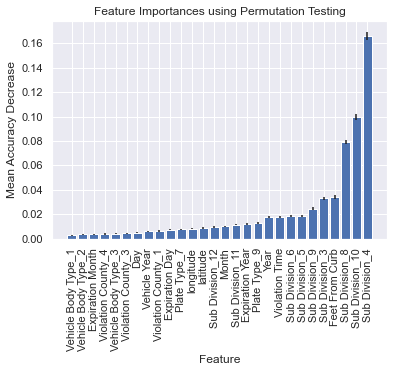

In [434]:
forest_dict1 = {}
for i in range(len(rccmodel[-1])):
    forest_dict1[rccmodel[-1][i]] = result.importances_mean[i]
    

lists = sorted(forest_dict1.items(), key=lambda t: t[::-1])
x1, y1 = zip(*lists)

ok1 = np.sort(result.importances_std)

ok1


import seaborn as sns
sns.set_theme(style="darkgrid")

plt.title("Feature Importances using Permutation Testing")
plt.ylabel("Mean Accuracy Decrease")
plt.xlabel("Feature")
plt.bar(x1[57:],y1[57:],yerr=ok1[57:])
plt.xticks(rotation = 90)
plt.plot()
plt.savefig('results/feature importances/Feature Importance - Accuracy.png', bbox_inches = 'tight')

In [497]:
lists

[('Vehicle Make_7', -9.379983116031276e-05),
 ('Plate Type_12', -9.379983116031276e-06),
 ('Vehicle Color_7', -9.379983116031276e-06),
 ('Plate Type_1', 0.0),
 ('Plate Type_13', 0.0),
 ('Plate Type_14', 0.0),
 ('Plate Type_15', 0.0),
 ('Plate Type_2', 0.0),
 ('Plate Type_3', 0.0),
 ('Plate Type_4', 0.0),
 ('Plate Type_6', 0.0),
 ('Plate Type_8', 0.0),
 ('Registration State_2', 0.0),
 ('Registration State_3', 0.0),
 ('Registration State_4', 0.0),
 ('Registration State_5', 0.0),
 ('Registration State_99', 0.0),
 ('Sub Division_14', 0.0),
 ('Sub Division_16', 0.0),
 ('Sub Division_27', 0.0),
 ('Sub Division_7', 0.0),
 ('Vehicle Body Type_8', 0.0),
 ('Vehicle Color_2', 0.0),
 ('Vehicle Make_8', 0.0),
 ('Registration State_1', 9.379983116031276e-06),
 ('Vehicle Make_9', 2.813994934809383e-05),
 ('Vehicle Color_12', 8.441984804428149e-05),
 ('Vehicle Make_4', 8.441984804428149e-05),
 ('Vehicle Body Type_5', 9.379983116031276e-05),
 ('Vehicle Body Type_6', 9.379983116031276e-05),
 ('Vehicle C

<Figure size 720x1440 with 0 Axes>

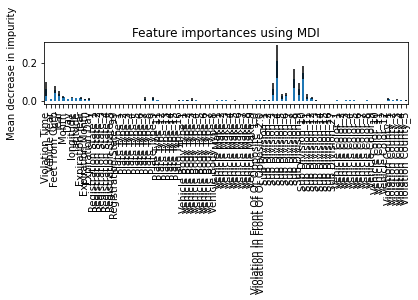

In [60]:
importances = rccmodel[0].best_estimator_[1].feature_importances_ 
std = np.std([tree.feature_importances_ for tree in rccmodel[0].best_estimator_[1].estimators_], axis=0)

forest_importances = pd.Series(importances, index=rccmodel[-1])

fig = plt.figure(figsize = (10,20))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

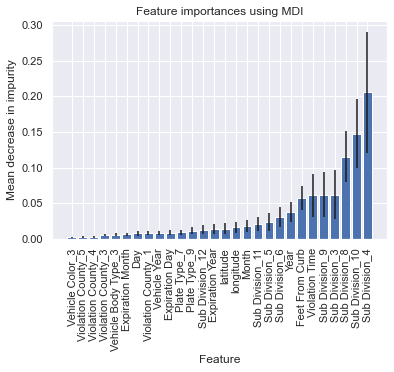

In [431]:
forest_dict2 = {}
for i in range(len(rccmodel[-1])):
    forest_dict[rccmodel[-1][i]] = importances[i]
    

lists = sorted(forest_dict.items(), key=lambda t: t[::-1])
x, y = zip(*lists)

ok = np.sort(std)

ok
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity")
plt.xlabel("Feature")
plt.bar(x[57:],y[57:],yerr=ok[57:])
plt.xticks(rotation = 90)
plt.plot()
plt.savefig('results/feature importances/Feature Importance - Mean Decrease in Impurity.png', bbox_inches = 'tight')

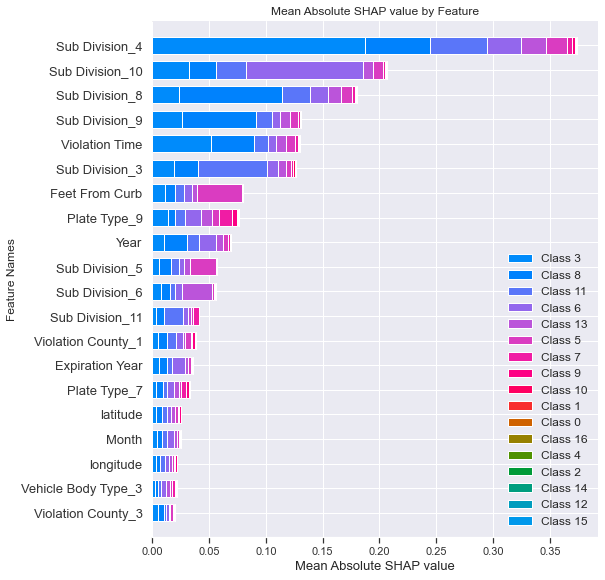

In [386]:
shap.summary_plot(shap_values, X_test_transformed[:1000], rccmodel[-1], show = False)

plt.ylabel('Feature Names')
plt.xlabel('Mean Absolute SHAP value')
plt.title("Mean Absolute SHAP value by Feature")
plt.plot()
plt.savefig('results/feature importances/Feature Importance - Mean SHAP value.png', bbox_inches = 'tight')

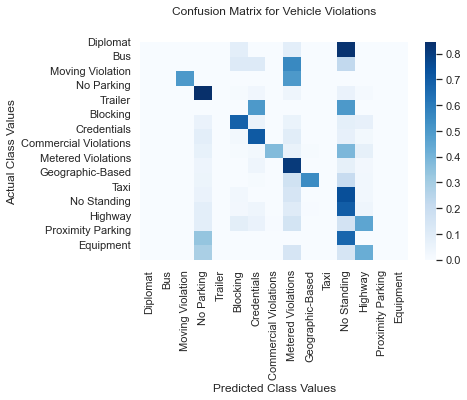

In [439]:
from sklearn.metrics import confusion_matrix, f1_score

cf = confusion_matrix(rccmodel[4], rccmodel[5], normalize='true')
cf.shape

group_percentages = ["{0:}".format(value) for value in cf.flatten()/np.sum(cf)]
labels = np.asarray(group_percentages).reshape(15,15)

import seaborn as sns

ax = sns.heatmap(cf, cmap = 'Blues')

plt.title("Confusion Matrix for Vehicle Violations",  y=1.1)
ax.set_xlabel("Predicted Class Values")
ax.set_ylabel("Actual Class Values")
ax.set_yticks(range(0,15))
fig.set_size_inches(11.7, 8.27)


ax.set_xticklabels(['Diplomat', 'Bus', 'Moving Violation', 'No Parking', 'Trailer', 
                    'Blocking', 'Credentials', 'Commercial Violations', 'Metered Violations', 
                    'Geographic-Based', 'Taxi', 'No Standing', 'Highway', 'Proximity Parking', 'Equipment'], rotation = 90)
ax.set_yticklabels(['Diplomat', 'Bus', 'Moving Violation', 'No Parking', 'Trailer', 
                    'Blocking', 'Credentials', 'Commercial Violations', 'Metered Violations', 'Geographic-Based', 'Taxi', 'No Standing', 'Highway', 'Proximity Parking', 'Equipment'], rotation = 0)


ax.plot()
plt.savefig('results/feature importances/Confusion Matrix - RFC.png', bbox_inches = 'tight')




In [168]:
f1_score(rccmodel[4], rccmodel[5], average = 'weighted')

0.7352145250091104

In [121]:
df['Violation Code'].value_counts()

400     75952
900     62422
1200    42618
700     40270
600     18913
1400    18851
800      3453
1000     2600
1100      797
100       245
200       185
1700       88
300        31
1500       27
500        21
1600       19
1300       18
Name: Violation Code, dtype: int64

In [493]:
index = 45
print(explainer.expected_value[3])
shap.force_plot(explainer.expected_value[3], shap_values[0][index,:],
                features = X_test_transformed[index,:],feature_names = ftr_names, show = False)

# plt.xticks(rotation = 90)
# plt.plot()

0.28519145623053543


### Decision Trees 

In [19]:
from sklearn.tree import DecisionTreeClassifier


param_trees = {"decisiontreeclassifier__max_depth":np.linspace(1,15,15)}

tree = DecisionTreeClassifier()


treemodel = MLpipe_sss_accuracy(X,y,preprocessor,tree,param_trees,seed_array)

tree_scores = []

tree_scores.append(treemodel[2])
print("test scores:", treemodel[2])

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Fitting 3 folds for each of 15 candidates, totalling 45 fits
test scores: [0.7473970546853016, 0.7413000656598818, 0.7497420504643092]


In [20]:
gridtree = treemodel[0]
X_testtree = treemodel[6]
y_testtree = treemodel[4]
namestree = treemodel[8]

import pickle
file = open('results/gridtree.save', 'wb')
pickle.dump((gridtree,X_testtree,y_testtree, namestree),file)
file.close()

### Gradient Boosted Trees

In [24]:
from sklearn.ensemble import GradientBoostingClassifier


param_grad = {"gradientboostingclassifier__learning_rate": [0.3],
             "gradientboostingclassifier__n_estimators":[1,3,10,30,50,100,150,300]}

bc = GradientBoostingClassifier()


gbcmodel = MLpipe_sss_accuracy(X,y,preprocessor,bc,param_grad,seed_array)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [25]:
gbc_scores = []

gbc_scores.append(gbcmodel[2])
print("test scores:", gbcmodel[2])

test scores: [0.6774223806397148, 0.6676671981990432, 0.6770471813150737]


In [26]:
gridgbc = gbcmodel[0]
X_testgbc = gbcmodel[6]
y_testgbc = gbcmodel[4]
namesgbc = gbcmodel[8]

import pickle
file = open('results/gridgbc.save', 'wb')
pickle.dump((gridgbc,X_testgbc,y_testgbc, namesgbc),file)
file.close()

### Naive Bayes

In [287]:
from sklearn.naive_bayes import BernoulliNB

param_nb = {"bernoullinb__alpha": np.logspace(-4,1,30)}

nb = BernoulliNB()

nbmodel = MLpipe_sss_accuracy(X,y,preprocessor,nb,param_nb,seed_array)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [289]:
nb_scores = []

nb_scores.append(nbmodel[2])
print("test scores:", nbmodel[2])

test scores: [0.6093237032173342, 0.6044461119969984, 0.608948503892693]


In [58]:
gridnb = nbmodel[0]
X_testnb = nbmodel[6]
y_testnb = nbmodel[4]
namesnb = nbmodel[8]

import pickle
file = open('results/gridnb.save', 'wb')
pickle.dump((gridnb,X_testnb,y_testnb, namesnb),file)
file.close()

## Ridge Classifier

In [53]:
from sklearn.linear_model import RidgeClassifier

param_ridge = {"ridgeclassifier__alpha": np.logspace(-4,1,30)}

ridge = RidgeClassifier(max_iter = 10^10, solver = 'auto', class_weight='balanced')

models = MLpipe_sss_accuracy(X,y,preprocessor, ridge, param_ridge, seed_array)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [195]:
ridge_scores = []

ridge_scores.append(models[2])
print("test scores:", models[2])

test scores: [0.5803395553888003, 0.5702091736234874, 0.5835287496482506]


In [99]:
ridgereg = models[0]
X_testridge = models[6]
y_testridge = models[4]
namesridge = models[8]

import pickle
file = open('results/gridlog.save', 'wb')
pickle.dump((ridgereg,X_testridge,y_testridge, namesridge),file)
file.close()

In [303]:
table_df = pd.DataFrame({'Naive Bayes': nb_scores,
                        "Random Forest Classifier":rcc_scores,
                        "Gradient Boosted Trees": gbc_scores, 
                       "Ridge Classifier":ridge_scores})

#gbc_scores = [0.6774223806397148, 0.6676671981990432, 0.6770471813150737]
#ridge_scores= np.array(ridge_scores)#nb_scores
# rcc_scores
nb_scores

[0.6093237032173342, 0.6044461119969984, 0.608948503892693]

In [302]:

nb_scores = [x for sublist in nb_scores for x in sublist]

In [304]:
df_scores = pd.DataFrame({"Mean Test Scores":np.mean(table_df,axis =0),
"Standard Deviation of Test Scores":np.std(table_df, axis = 0)})

In [305]:
df_scores.save

,Mean Test Scores,Standard Deviation of Test Scores
Naive Bayes,0.607573,0.002216
Random Forest Classifier,0.735547,0.004227
Gradient Boosted Trees,0.674046,0.004513
Ridge Classifier,0.578026,0.005678


Naive Bayes Scores                 0.607385
Random Forest Classifier Scores    0.735547
Gradient Boosted Trees Scores      0.674046
Ridge Classifier Scores            0.578026
dtype: float64
Naive Bayes Scores                 0.002015
Random Forest Classifier Scores    0.004227
Gradient Boosted Trees Scores      0.004513
Ridge Classifier Scores            0.005678
dtype: float64


Text(0.5, 1.0, 'Summary of Model Performances')

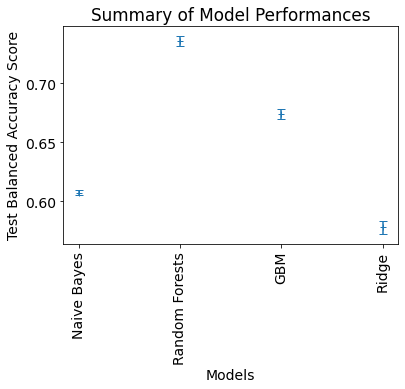

In [245]:
table_df

print(np.mean(table_df, axis = 0))
print(np.std(table_df, axis = 0))

plt.errorbar(range(0,4), np.mean(table_df,axis =0), 
             yerr = np.std(table_df, axis = 0), ls = 'none', capsize = 4, fmt = "+")
plt.xticks(range(0,4), labels = ['Naive Bayes', 'Random Forests', 'GBM', 'Ridge'], rotation = 90)
plt.xlabel('Models')
plt.ylabel('Test Balanced Accuracy Score')
plt.title("Summary of Model Performances")

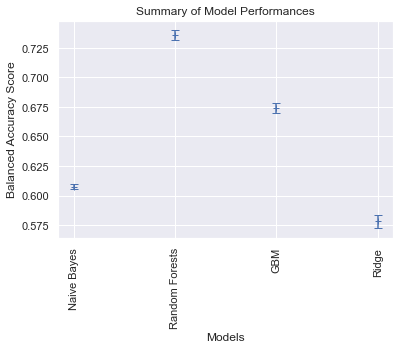

In [292]:
sns.set_theme(style="darkgrid")
plt.errorbar(range(0,4), np.mean(table_df,axis =0), 
             yerr = np.std(table_df, axis = 0), ls = 'none', capsize = 4, fmt = "+")
plt.xticks(range(0,4), rotation = 90, 
           labels = ['Naive Bayes', 'Random Forests', 'GBM', 'Ridge'])
plt.xlabel('Models')
plt.ylabel('Balanced Accuracy Score')
plt.title("Summary of Model Performances")
plt.plot()

plt.savefig("figures/Summary of Model Performance.png", bbox_inches = 'tight')

In [279]:
np.logspace(-4,1,30)

array([1.00000000e-04, 1.48735211e-04, 2.21221629e-04, 3.29034456e-04,
       4.89390092e-04, 7.27895384e-04, 1.08263673e-03, 1.61026203e-03,
       2.39502662e-03, 3.56224789e-03, 5.29831691e-03, 7.88046282e-03,
       1.17210230e-02, 1.74332882e-02, 2.59294380e-02, 3.85662042e-02,
       5.73615251e-02, 8.53167852e-02, 1.26896100e-01, 1.88739182e-01,
       2.80721620e-01, 4.17531894e-01, 6.21016942e-01, 9.23670857e-01,
       1.37382380e+00, 2.04335972e+00, 3.03919538e+00, 4.52035366e+00,
       6.72335754e+00, 1.00000000e+01])